# Siamese Neural Network for Building Damage Classication

The main goal of this file is to utalize the siamese network architecture to train our model. The purpose for using this model is to be able to incorperate the pre-disaster and post-disaster images into the model input for better classification.


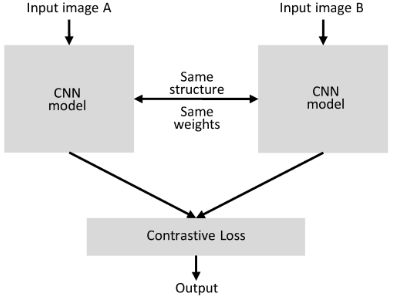

**Initial Research Source List:**
1.  https://pyimagesearch.com/2020/11/23/building-image-pairs-for-siamese-networks-with-python/
2. https://towardsdatascience.com/siamese-networks-introduction-and-implementation-2140e3443dee

**Background:**

Siamese Networks are designed to output a binary response to an input of two images. A Siamese Network will decide if 2 input images are within the same class, it outputs a 1 for yes and a 0 for no. Therefore when inputting in a pre-disaster and post-distaster image, then if the model returns a 1 then it is known that the post-disaster image should be classified as no damage since it is comparable to the origional. Where as if it outputs a 0, then the building was damaged in some capacity and further analysis needs to be done.


Alot of the code for the first part of this cell is reused from the CNN code, however modified slightly so that both the pre and the post images are properly used

# Part 1: Libraries and mounting Drive



Generate the pairs of data and their labels. According to the second source linked above, the data should be seperated into pairs where some of the pairs are correspionding to a 1 output and some to a 0 output. So Ill build arrays of buildings such that they are seperated by damage label. A no-damage array, a minor, a major, and a destoryed array




In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Whos Currently Running?
NAME = "PAT"

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Commonly used modules
import numpy as np
import os
import sys
import json
import math

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import IPython
from six.moves import urllib
from google.colab.patches import cv2_imshow as show

print(tf.__version__)

2.15.0


# Part 2: Pre-Processing Functions

In [ ]:
# Preprocessing Functions:

# get the points of each polygon that represents a building
def get_points(json_building):
  #split the string
  spaces = building['wkt'].split(' ')

  # print(spaces)

  #remove the first element 'POLYGON'
  spaces.pop(0)

  #remove the parenthesis from the first element
  spaces[0] = spaces[0][2::]

  #remove the parethesis of the last element
  spaces[len(spaces)-1] = spaces[len(spaces)-1][:-2]

  #get rid of the commas in the second point
  for i in range(len(spaces)):
    spaces[i] = spaces[i].replace(",","")

  # print(spaces)

  #make them integers and tuples for points
  points = []
  for i in range(0,len(spaces),2):
    points.append((int(float(spaces[i])), int(float(spaces[i+1]))))

  points = np.array(points)

  return points

# make all images the same dimensions
def make_same_dimensions(images, size):

  # find max row,cols of all images
  # max_rows = 0
  # max_cols = 0
  # for img in images:
  #   curr_rows, curr_cols, _ = img.shape
  #   if curr_rows > max_rows:
  #     max_rows = curr_rows
  #   if curr_cols > max_cols:
  #     max_cols = curr_cols

  # print("Max rows : " + str(max_rows))
  # print("Max cols: " + str(max_cols))

  # square_dim = max(max_rows , max_cols)
  square_dim = size

  # print("square_dim: " + str(square_dim))

  new_images = []
  img_count = 1

  # make all images have same dimensions
  for pair in images:

    # print("\nimage " + str(img_count))
    img_count+=1
    #print(str(img_count) + ": " + str(img.shape))

    # print("curr_rows : " + str(curr_rows))
    # print("curr_cols: " + str(curr_cols))

    new_img0 = pair[0]
    new_img1 = pair[1]
    curr_rows , curr_cols, _ = new_img0.shape


    if curr_rows > square_dim:        #dsize is (width,height) which is -> (cols,rows)
      new_img0 = cv2.resize(new_img0, dsize=(curr_cols,square_dim), interpolation=cv2.INTER_CUBIC)
      curr_rows , curr_cols, _ = new_img0.shape

      #do the same thing to newimg1
      new_img1 = cv2.resize(new_img1, dsize=(curr_cols,square_dim), interpolation=cv2.INTER_CUBIC)




    if curr_cols > square_dim:
      new_img0 = cv2.resize(new_img0, dsize=(square_dim,curr_rows), interpolation=cv2.INTER_CUBIC)
      curr_rows , curr_cols, _ = new_img0.shape

      new_img1 = cv2.resize(new_img1, dsize=(square_dim,curr_rows), interpolation=cv2.INTER_CUBIC)





    curr_rows , curr_cols, _ = new_img0.shape
    # add to cols of image if needed
    if square_dim > curr_cols:
      difference = square_dim - curr_cols

      # print("difference in cols: " + str(difference))

      # creates column array with $rows number of rows
      d = np.array([[[0, 0, 0]] for x in range(curr_rows)])
      # print(d.shape)

      # case where you just add one col to the img
      if difference == 1:
          new_img0 = np.hstack((new_img0, d))
          new_img1 = np.hstack((new_img1, d))
      # case where you add equal amount to left and right of image
      else:
        # add one col to left and right of img
        new_img0 = np.hstack((new_img0, d))
        new_img0 = np.hstack((d, new_img0))

        new_img1 = np.hstack((new_img1, d))
        new_img1 = np.hstack((d, new_img1))

        # add rest of cols to left/right of img
        for i in range(math.floor(difference/2)-1):
          new_img0 = np.hstack((new_img0, d))
          new_img0 = np.hstack((d, new_img0))

          new_img1 = np.hstack((new_img1, d))
          new_img1 = np.hstack((d, new_img1))


        # if difference is odd, have an extra column to add
        if difference%2 == 1:
          new_img0 = np.hstack((new_img0, d))
          new_img1 = np.hstack((new_img1, d))


    # update variables to match updated image
    curr_rows , curr_cols, _ = new_img0.shape

    # add to rows of image if needed
    if square_dim > curr_rows:
      difference = square_dim - curr_rows

      # print("difference in rows: " + str(difference))

      # creates row array with $height number of cols
      d = np.array([[[0, 0, 0] for x in range(curr_cols)]])
      # print(d.shape)

      # case where you just add one row to the img
      if difference == 1:
          new_img0 = np.vstack((new_img0, d))
          new_img1 = np.vstack((new_img1, d))
      # case where you add equal amount to top and bottom of image
      else:
        # add one col to left and right of img
        new_img0 = np.vstack((new_img0, d))
        new_img0 = np.vstack((d, new_img0))

        new_img1 = np.vstack((new_img1, d))
        new_img1 = np.vstack((d, new_img1))

        # add rest of cols to left/right of img
        for i in range(math.floor(difference/2)-1):
          new_img0 = np.vstack((new_img0, d))
          new_img0 = np.vstack((d, new_img0))

          new_img1 = np.vstack((new_img1, d))
          new_img1 = np.vstack((d, new_img1))


        # if difference is odd, have an extra column to add
        if difference%2 == 1:
          new_img0 = np.vstack((new_img0, d))
          new_img1 = np.vstack((new_img1, d))

    new_rows, new_cols, _ = new_img0.shape

    #if new_rows != 150 or new_cols != 150:
      #print("old dim: ", img[0].shape)
      #print("new dim:", new_img0.shape)

    # print("\nnew_rows: " + str(new_rows))
    # print("new_cols: " + str(new_cols))

    new_images.append([new_img0,new_img1])

  return new_images

# given json data of building, create cropped image of just the building from the entire image
def crop_image(building, img):
  points = get_points(building)
  # print(points)
  sum_x = 0
  sum_y = 0
  for x,y in points:
    sum_x += x
    sum_y += y

  center_x = round(sum_x/len(points))
  center_y = round(sum_y/len(points))
  # print(center_x)
  # print(center_y)
  # image[ miny:maxy, minx:maxx]
  # show(img_post[center_y-50:center_y+50, center_x-50:center_x+50])

  # source for below code: https://stackoverflow.com/questions/48301186/cropping-concave-polygon-from-image-using-opencv-python

  rect = cv2.boundingRect(points)
  x,y,w,h = rect

  croped = img[y:y+h, x:x+w].copy()

  ## (2) make mask
  pts = points - points.min(axis=0)

  mask = np.zeros(croped.shape[:2], np.uint8)
  cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)

  ## (3) do bit-op
  dst = cv2.bitwise_and(croped, croped, mask=mask)

  return dst

## **Getting Images by Disaster Name**


In [ ]:
# Will need to change based on who's running

# Identify user and pull base directory path
if NAME == "PAT":
  base_dir = '/content/drive/MyDrive/Capstone Project/Dataset1/train/images/'
elif NAME == "ALAN":
  base_dir = "/content/drive/MyDrive/SeniorSpring/ENEE439D/Capstone Project/Dataset1/train/images/"
elif NAME == "ANDY":
  base_dir = '/content/drive/MyDrive/Spring 2024/ENEE 439D/Capstone Project/Dataset1/train/images/'
else:
  raise Exception("Invalid user")

# Specify disaster name, so training and testing based on disaster subset
# Select from: guatemala-volcano (16 images), hurricane-florence, hurricane-harvey,
#              hurricane-michael, hurricane-matthew, socal-fire, santa-rosa-wildfire,
#              midwest-flooding, palu-tsunami, or mexico-earthquake
disaster_name = 'guatemala-volcano'

curr_count_train = 0
curr_count_test = 0
count_train = 11
count_test = 4#500
images_train = []
json_images_train = []

images_test = []
json_images_test = []
train = True

for file in os.listdir(base_dir):
  if disaster_name in file and file.endswith("post_disaster.png"):
    if train:
      curr_count_train+=1
    else:
      curr_count_test+=1

    #make the pre and post images a pair:
    img_path = base_dir+file
    pre_img_path = base_dir+file.replace('post_disaster.png',"pre_disaster.png")
    post_img_path = base_dir+file
    pre_post_pair = [pre_img_path,post_img_path]

    if train:
      images_train.append(pre_post_pair)
    else:
      images_test.append(pre_post_pair)


    # get the json data
    label_path = img_path.replace('png', 'json').replace('images', 'labels')
    with open(label_path, "rb") as file:
        data = json.load(file)
    if train:
      json_images_train.append(data)
    else:
      json_images_test.append(data)

    if curr_count_train >= count_train:
      train = False

    if not train and curr_count_test >= count_test:
      break

In [ ]:
count = 1
for pair in images_train:
    #filename = os.path.basename(path)
    print(str(count) + ": " + os.path.basename(pair[0]) + " || " + os.path.basename(pair[1]))
    count = count + 1

1: guatemala-volcano_00000016_pre_disaster.png || guatemala-volcano_00000016_post_disaster.png
2: guatemala-volcano_00000015_pre_disaster.png || guatemala-volcano_00000015_post_disaster.png
3: guatemala-volcano_00000007_pre_disaster.png || guatemala-volcano_00000007_post_disaster.png
4: guatemala-volcano_00000013_pre_disaster.png || guatemala-volcano_00000013_post_disaster.png
5: guatemala-volcano_00000023_pre_disaster.png || guatemala-volcano_00000023_post_disaster.png
6: guatemala-volcano_00000018_pre_disaster.png || guatemala-volcano_00000018_post_disaster.png
7: guatemala-volcano_00000024_pre_disaster.png || guatemala-volcano_00000024_post_disaster.png
8: guatemala-volcano_00000017_pre_disaster.png || guatemala-volcano_00000017_post_disaster.png
9: guatemala-volcano_00000010_pre_disaster.png || guatemala-volcano_00000010_post_disaster.png
10: guatemala-volcano_00000019_pre_disaster.png || guatemala-volcano_00000019_post_disaster.png
11: guatemala-volcano_00000026_pre_disaster.png |

## **Converting Images into building arrays**

In [ ]:
#compared t0 the origional, images_train is now a 2D array with the pre and post images

train_images = []
train_labels = []

for i in range(len(images_train)):

  #pre and post labels
  img_pre_path = images_train[i][0]
  img_post_path = images_train[i][1]

  img_path = images_train[i]
  data = json_images_train[i]

  #pre and post
  img_pre = cv2.imread(img_pre_path)
  img_post = cv2.imread(img_post_path)

  for building in data['features']['xy']:
    damage_label = building["properties"]["subtype"]
    if damage_label != "un-classified":
      cropped_img_pre = crop_image(building, img_pre)
      cropped_img_post = crop_image(building,img_post)
      #buildings_train.append(cropped_img)
      train_images.append([cropped_img_pre,cropped_img_post])


      if damage_label == "no-damage":
        train_labels.append(0)
      if damage_label == "minor-damage":
        train_labels.append(1)
      if damage_label == "major-damage":
        train_labels.append(2)
      if damage_label == "destroyed":
        train_labels.append(3)


train_images = make_same_dimensions(train_images, 64) #was 150, making 300#make_same_dimensions(buildings_train, 300) #was 150, making 300

#buildings_test = []
test_images = []
test_labels = []

for i in range(len(images_test)):

  #pre and post labels
  img_pre_path = images_train[i][0]
  img_post_path = images_train[i][1]


  img_path = images_test[i]
  data = json_images_test[i]

  #pre and post
  img_pre = cv2.imread(img_pre_path)
  img_post = cv2.imread(img_post_path)

  for building in data['features']['xy']:
    damage_label = building["properties"]["subtype"]
    if damage_label != "un-classified":
      cropped_img_pre = crop_image(building, img_pre)
      cropped_img_post = crop_image(building,img_post)
      #buildings_train.append(cropped_img)
      test_images.append([cropped_img_pre,cropped_img_post])


      if damage_label == "no-damage":
        test_labels.append(0)
      if damage_label == "minor-damage":
        test_labels.append(1)
      if damage_label == "major-damage":
        test_labels.append(2)
      if damage_label == "destroyed":
        test_labels.append(3)

test_images = make_same_dimensions(test_images, 64) #make_same_dimensions(buildings_test, 300)#was 150 making 300

#assign old arrs to None to save space?
buildings_test = None
buildings_train = None


#for i in range(0,len(train_images)):
  #if train_labels[i] != 0:
    #print("Pair #" + str(i))
    #show(train_images[i][0])
    #show(train_images[i][1])
    #print(train_labels[i])



Now The images are paried up with their pre and post versions. For the siamese network, they have to be broken up into different catigories, all of the pairs that are classified as no damage are the positive group, and all the other labels are the negative group

In [ ]:
#iterate through the samples looking for the label 0, if zero it is a positive score as this is no damage, and if not then it is a negative since there was damage

no_damage_pairs_train = []
some_damage_pairs_train = []

no_damage_pairs_test = []
some_damage_pairs_test = []

for i in range(len(train_labels)):
  if train_labels[i] == 0:
    no_damage_pairs_train.append(train_images[i])
  else:
    some_damage_pairs_train.append(train_images[i])

for i in range(len(test_labels)):
  if train_labels[i] == 0:
    no_damage_pairs_test.append(test_images[i])
  else:
    some_damage_pairs_test.append(test_images[i])



print("No Damage Pairs Train " + str(len(no_damage_pairs_train)))
print("Some Damage Pairs Train " + str(len(some_damage_pairs_train)))
print("No Damage Pairs Test " + str(len(no_damage_pairs_test)))
print("Some Damage Pairs Test " + str(len(some_damage_pairs_test)))



No Damage Pairs Train 507
Some Damage Pairs Train 11
No Damage Pairs Test 148
Some Damage Pairs Test 2


# Part 3: Building A Siamese Network

A Siamese Network is two networks with the same structure working in paralled to one another, then the outputs of the two parallel models are compared using a dot product.

As a starting point, I'll use the model that was created in this article, but adjusting paramaters as nessassary to fit my data. Later through experimentation, we will change up the model to further experiment:

https://towardsdatascience.com/siamese-networks-introduction-and-implementation-2140e3443dee


From this paper outlining their attempt at this same classification problem:
https://isprs-archives.copernicus.org/articles/XLIII-B3-2022/1133/2022/isprs-archives-XLIII-B3-2022-1133-2022.pdf

They used the siamese model as an encoder, then attached a decoder model to the output to decide on the classification. Because of this, I used this approach for building the Siamese Neural Network.

In [ ]:
#this is the baseline model from the article
from keras.layers import Input, Dense, InputLayer, Conv2D, MaxPooling2D, UpSampling2D, InputLayer, Concatenate, Flatten, Reshape, Lambda, Embedding, dot, GlobalAveragePooling2D
from keras.models import Model, load_model, Sequential
import tensorflow.keras.backend as K
from keras import metrics
from keras.optimizers import SGD

#Model using our Baseline CNN
input_layer = Input((64, 64, 3))
layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
layer2 = MaxPooling2D((2, 2), padding='same')(layer1)
layer3 = Conv2D(128, (3, 3), activation='relu', padding='same')(layer2)
layer4 = MaxPooling2D((2, 2), padding='same')(layer3)
layer5 = Conv2D(256, (3, 3), activation='relu', padding='same')(layer4)
layer6 = MaxPooling2D((2, 2), padding='same')(layer5)
layer7 = Conv2D(512, (3, 3), activation='relu', padding='same')(layer6)
layer8 = MaxPooling2D((2, 2), padding='same')(layer7)
layer9 = Dropout(0.25)(layer8)
layer10 = Flatten()(layer9)
layer11 = Dense(1024,activation = 'relu')(layer10)
layer12 = Dropout(0.25)(layer11)
#layer9 = GlobalAveragePooling2D()(layer8)
layer13 = Dense(144)(layer12)
#layer14 = Dense(64)(layer13)


#references are saying to not have this 2 node output for classification.....

#layer8 = Dense(2, activation='softmax')(layer7)

#output 32 features for each image? probably tunable, from reference link
#embeddings = Dense(2, activation='softmax')(layer7)
#norm = tf.nn.l2_normalize(layer9, axis=-1)
#norm_embeddings = tf.nn.l2_normalize(embeddings, axis=-1)

# Create model
base_model = Model(inputs=input_layer, outputs=layer13)


#create the siamese modeling:
input_pre = Input((64,64,3))
input_post = Input((64,64,3))

pre_model = base_model(input_pre)
post_model = base_model(input_post)

#rather than dot layer, this source reccomends a euclidian distance layer:
#https://pyimagesearch.com/2020/11/30/siamese-networks-with-keras-tensorflow-and-deep-learning/


def euclidean_distance(vectors):    #try this as a layer https://pyimagesearch.com/2020/11/30/siamese-networks-with-keras-tensorflow-and-deep-learning/
	# unpack the vectors into separate lists
	(featsA, featsB) = vectors
	# compute the sum of squared distances between the vectors
	sumSquared = K.sum(K.square(featsA - featsB), axis=1, keepdims=True)
	# return the euclidean distance between the vectors
	return K.sqrt(K.maximum(sumSquared, K.epsilon()))


distance = Lambda(euclidean_distance)([pre_model, post_model])
output = Dense(1, activation="sigmoid")(distance)


#according to the paper, concat the premodel and post model outputs together, and feed into another network for classification
#inputb = Concatenate()([pre_model,post_model])
#layer0b = Flatten()(inputb)
#layer1b = Dense(32,activation = 'relu')(layer0b)
#layer2b = Dropout(0.5)(layer1b)
#layer3b = Dense(16, activation = 'relu')(layer2b)
#layer4b = Dropout(0.25)(layer3b)
#layer5b = Dense(8, activation = 'relu')(layer4b)
#output = Dense(1, activation = 'sigmoid')(layer5b)


siamese_model = Model(inputs=[input_pre, input_post], outputs=output)

# Model summary
print(siamese_model.summary())


#compile the model
#opt = Adam(learning_rate = 0.001)
siamese_model.compile(optimizer='adam', loss= 'binary_crossentropy',metrics = ['accuracy'])



Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 input_18 (InputLayer)       [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 model_10 (Functional)       (None, 144)                  1008820   ['input_17[0][0]',            
                                                          8          'input_18[0][0]']            
                                                                                                  
 lambda_5 (Lambda)           (None, 1)                    0         ['model_10[0][0]',     

#Part 4: Train the Siamese Model


In [ ]:

#seperate the pre and post and new labels
pre = []
post = []
labels = []
#no damage labels
for i in range(len(no_damage_pairs_train)):
  pre.append(no_damage_pairs_train[i][0])
  post.append(no_damage_pairs_train[i][1])
  labels.append(1)
#some damage labels
for i in range(len(some_damage_pairs_train)):
  pre.append(some_damage_pairs_train[i][0])
  post.append(some_damage_pairs_train[i][1])
  labels.append(0)


#convert to np arrays
pre = np.array(pre)
post = np.array(post)
labels = np.array(labels)

#try using class weighting as per this stackoverflow post:
#https://stackoverflow.com/questions/37213388/keras-accuracy-does-not-change
#https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

from sklearn.utils import compute_class_weight
classWeight = compute_class_weight('balanced', classes = np.unique(labels), y = labels)
classWeight = dict(enumerate(classWeight))

siamese_model.fit([pre, post], labels, epochs=10,batch_size = 16,shuffle=True, verbose=True, class_weight = classWeight)


Epoch 1/10
33/33 [==============================] - 5s 50ms/step - loss: 29.4406 - accuracy: 0.9788
Epoch 2/10
33/33 [==============================] - 1s 21ms/step - loss: 0.8648 - accuracy: 0.9788
Epoch 3/10
33/33 [==============================] - 1s 21ms/step - loss: 0.6657 - accuracy: 0.9788
Epoch 4/10
33/33 [==============================] - 1s 21ms/step - loss: 0.7052 - accuracy: 0.9788
Epoch 5/10
33/33 [==============================] - 1s 21ms/step - loss: 0.7570 - accuracy: 0.9788
Epoch 6/10
33/33 [==============================] - 1s 21ms/step - loss: 0.6760 - accuracy: 0.9788
Epoch 7/10
33/33 [==============================] - 1s 21ms/step - loss: 1.0259 - accuracy: 0.9710
Epoch 8/10
33/33 [==============================] - 1s 21ms/step - loss: 0.7423 - accuracy: 0.9189
Epoch 9/10
33/33 [==============================] - 1s 21ms/step - loss: 0.7398 - accuracy: 0.8880
Epoch 10/10
33/33 [==============================] - 1s 22ms/step - loss: 0.6935 - accuracy: 0.9054


# Part 5: Test the Siamese Model for Building Classification Accuracy

Now that the siamese model has been trained using the pre and post image data, input the testing dataset

In [ ]:
#get the testing data set up
#seperate the pre and post and new labels
pre_test = []
post_test = []
labels_test = []
#no damage labels
for i in range(len(no_damage_pairs_test)):
  pre_test.append(no_damage_pairs_test[i][0])
  post_test.append(no_damage_pairs_test[i][1])
  labels_test.append(1)
#some damage labels
for i in range(len(some_damage_pairs_test)):
  pre_test.append(some_damage_pairs_test[i][0])
  post_test.append(some_damage_pairs_test[i][1])
  labels_test.append(0)


#convert to np arrays
pre_test = np.array(pre_test)
post_test = np.array(post_test)
labels_test = np.array(labels_test)

#test on the post disaster images and see what it classifies as
model_predictions = siamese_model.predict([pre_test,post_test])



#print(model_predictions)
#print(model_predictions.shape)
#print(labels_test.shape)
preds = []
for i in range(len(model_predictions)):
  #maximum = max(model_predictions[i][0],model_predictions[i][1])
  #if maximum == model_predictions[i][0]:
  if model_predictions[i] < 0.5:
    preds.append(0)
  else:
    preds.append(1)

matrix = tf.math.confusion_matrix(labels_test,preds)

#compute accuracy
correctCount = 0
for i in range(len(labels_test)):
  if labels_test[i] == preds[i]:
    correctCount +=1

print("Accuracy:", correctCount/len(labels_test))

print(matrix)

5/5 [==============================] - 1s 154ms/step
Accuracy: 0.32
tf.Tensor(
[[  2   0]
 [102  46]], shape=(2, 2), dtype=int32)


[102, 46]


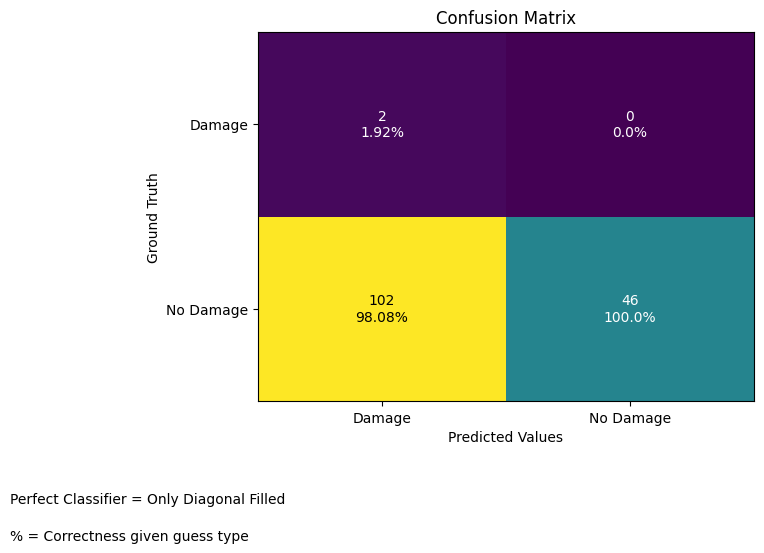

In [ ]:
#same as my visualize code from before but for 2x2, and the labels put in the appropriate places
def visualize_confusion_matrix(matrix):
  #build the data array, flipping the order of the rows
  #this is nessassary since the pcolormesh has 0 at the bottom rather than top like a typical
  #confusion matrix
  data = []
  for row in range(0,2):
    currCol = []
    for col in range(0,2):
      currCol.append(matrix[row][col].numpy())
    data.insert(0,currCol)

  print(data[0])
  #use the pcolormesh function, following the documentations
  Z = data
  x = np.arange(0,2,1)
  y = np.arange(0,2,1)

  maxVal = max(max(data[0]),max(data[1]))

  fig, ax = plt.subplots()
  ax.pcolormesh(x, y, Z, cmap = 'viridis')

  #calculate percentages of the columns for annotation
  percentages = []
  for col in range(0,2):
    currCol = []
    sum = 0
    #gets the total guesses
    for i in range(0,2):
      sum = sum + data[i][col]
    #calculates percentages
    for i in range(0,2):
      if sum != 0:
        currCol.append((data[i][col]/sum) * 100)
      else:
        currCol.append(0.00)
    percentages.append(currCol)

  #adding text annotations in boxes
  for i in range(0,2):
    for j in range(0,2):
      #change the text color if nessassary, 75% of max make the text black
      if data[i][j] < maxVal*0.75:
        text = ax.text(j, i, str(data[i][j]) + "\n" +str(round(percentages[j][i],2)) + "%" , ha="center", va="center", color="w")
      else:
         text = ax.text(j, i, str(data[i][j]) + "\n" +str(round(percentages[j][i],2)) + "%" , ha="center", va="center", color="k")

  #add additional text to bottom corner
  ax.text(-1.5,-1.05, "Perfect Classifier = Only Diagonal Filled")
  ax.text(-1.5,-1.25, "% = Correctness given guess type")
  #ax.text(-1.5,-1.45, "# of Train Buildings: " + str(train_images.shape[0]))
  #ax.text(-1.5,-1.65, "# of Test Buildings: " + str(test_images.shape[0]))


  #axes info
  classLabelsX = ["Damage","No Damage"]
  classLabelsY = ["No Damage", "Damage"]
  ax.set_xticks(np.arange(2), labels=classLabelsX)
  ax.set_yticks(np.arange(2), labels=classLabelsY)

  #plots the confusion matrix with titles
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted Values")
  plt.ylabel("Ground Truth")
  plt.show()

#calls the function
visualize_confusion_matrix(matrix)